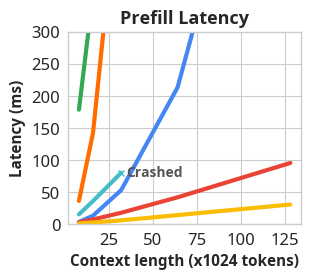

<Figure size 640x480 with 0 Axes>

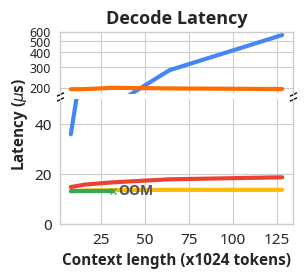

<Figure size 640x480 with 0 Axes>

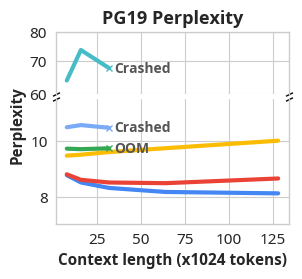

<Figure size 640x480 with 0 Axes>

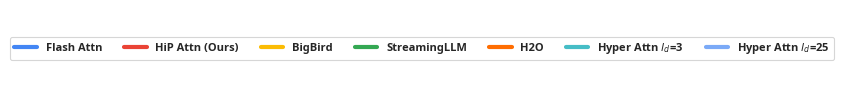

In [91]:
import math
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
label_size = 12
mpl.rcParams['xtick.labelsize'] = label_size

def proc_copy_paste(t: str, scale: float = 1):
    return list(map(lambda x: float(x) * scale, t.split()))

FLASH_ATTN = 'Flash Attn'
HIP_ATTN = 'HiP Attn'
BIGBIRD = 'BigBird'
SLLM = 'StreamingLLM'
H2O = 'H2O'
HYPER_ATTN = 'Hyper Attn'

Ts = [8, 16, 32, 64, 128]

FIGSIZE = (3.0, 2.5)

DEAD_REASON = {
    HYPER_ATTN: 'Crashed',
    SLLM: 'OOM',
}

prefill_data = {
    FLASH_ATTN: proc_copy_paste('3.82	13.49	53.47	213.46	861.40'),
    HIP_ATTN: proc_copy_paste('3.22	7.67	18.14	42.20	95.69'),
    BIGBIRD: proc_copy_paste('1.41	2.87	6.30	14.47	30.97'),
    SLLM: proc_copy_paste('178.8	359.5	721.2	NaN	NaN'),
    H2O: proc_copy_paste('36.6	142.6	569.5	2563	12576'),
    HYPER_ATTN: proc_copy_paste('15.65	36.40	80.52	NaN	NaN'),
}

decode_data = {
    FLASH_ATTN: proc_copy_paste('0.0360	0.0713	0.1418	0.2822	0.5639', scale=1000),
    HIP_ATTN: proc_copy_paste('0.0149	0.0159	0.0168	0.0180	0.0188', scale=1000),
    BIGBIRD: proc_copy_paste('0.0131	0.0135	0.0137	0.0138	0.0138', scale=1000),
    SLLM: proc_copy_paste('0.0134	0.0134	0.0134	NaN	NaN', scale=1000),
    H2O: proc_copy_paste('0.1941	0.1946	0.1996	0.1972	0.1949', scale=1000),
    # HYPER_ATTN: proc_copy_paste('NaN	NaN	NaN	NaN	NaN', scale=1000),
}

pg19_data = {
    FLASH_ATTN: proc_copy_paste('8.7684	8.5071	8.3100	8.1655	8.1151'),
    HIP_ATTN: proc_copy_paste('8.7994	8.6028	8.5057	8.4810	8.6499'),
    BIGBIRD: proc_copy_paste('9.4713	9.5047	9.5993	9.7382	10.0082'),
    SLLM: proc_copy_paste('9.7224	9.7039	9.7342	NaN	NaN'),
    'placeholder': None,
    HYPER_ATTN: {
        '$l_d$=3': proc_copy_paste('63.9827	73.6145	67.735	NaN	NaN'),
        '$l_d$=25': proc_copy_paste('10.4919	10.5695	10.4721	NaN	NaN'),
    }
}

wt2_data = {
    FLASH_ATTN: proc_copy_paste('5.6080	5.4728	5.3986	5.3470	5.3467'),
    HIP_ATTN: proc_copy_paste('5.6179	5.5037	5.4529	5.4305	5.5889'),
    H2O: {
        '': proc_copy_paste('5.9855	6.0205	6.0843	6.1506	6.2805'),
        # 'stream': proc_copy_paste('6.5778	6.5412	6.5701	6.6008	6.7079'),
    }
}

from hip.utils import setup_seaborn
setup_seaborn(
    label_fontsize=11,
    legend_fontsize=8,
    axes_label_fontsize=8,
    axis_below=True,
)

import seaborn as sb

working_directory = './saves/plot_ppl/'
os.makedirs(working_directory, exist_ok=True)

def render(plot_data: dict, figsize=FIGSIZE, reset_figure=True, ax=None, text_offset_scale_y=0.9):
    if reset_figure:
        plt.figure(figsize=figsize)
    
    def render_line(xs, ys, label, i, method=None):
        line_ax = sb.lineplot(x=xs, y=ys, label=label, ax=ax, legend=False, linewidth=3.0, color=f"C{i}")
        if any(map(math.isnan, ys)):
            for last_okay, y in enumerate(ys):
                if math.isnan(y):
                    last_okay -= 1
                    break
            last_okay_x = xs[last_okay]
            last_okay_y = ys[last_okay]
            base_color = line_ax.lines[-1].get_color()
            #line_color = tuple(map(lambda x: x*0.66, base_color))
            #font_color = tuple(map(lambda x: x*0.66, base_color))
            font_color = '#555555'
            (ax if ax is not None else plt).annotate(
                DEAD_REASON[method], 
                xy=(last_okay_x, last_okay_y), 
                xytext=(last_okay_x + 3, last_okay_y),
                fontsize=10,
                va='center',
                fontweight=800,
                linespacing=0.9,
                color=font_color,
                # arrowprops=dict(
                #     # width=2,
                #     # headwidth=4,
                #     # headlength=4,
                #     shrinkA=0,
                #     shrinkB=0,
                #     relpos=(0.0,0.5),
                #     arrowstyle = '-|>',
                #     linestyle='-',
                #     linewidth=0.5,
                #     edgecolor=line_color,
                #     facecolor=line_color, 
                #     # connectionstyle = 'arc3',
                #     # facecolor=line_color,
                # )
            )
            (ax if ax is not None else plt).plot(
                [last_okay_x], [last_okay_y],
                marker='x', color=base_color,
                markeredgewidth=1
            )

    i = 0
    for label, data in plot_data.items():
        if isinstance(data, dict):
            for inner_label, inner_data in data.items():
                render_line(Ts, inner_data, f'{label} {inner_label}', i, method=label)
                i += 1
        elif data is None:
            i += 1
        else:
            render_line(Ts, data, label, i, method=label)
            i += 1
    if reset_figure:
        plt.grid(True)
    return

render(prefill_data, text_offset_scale_y=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Prefill Latency', fontsize=13)
plt.ylim(0, 300)
#plt.legend(loc='upper right')
plt.xlabel('Context length (x1024 tokens)')
plt.ylabel('Latency (ms)')
plt.savefig(os.path.join(working_directory, 'plot_ppl_prefill.png'), bbox_inches='tight', pad_inches=0)
plt.savefig(os.path.join(working_directory, 'plot_ppl_prefill.pdf'), bbox_inches='tight', pad_inches=0)
plt.show()

def split_plot(plot_data, range1, range2, legend_anchor, text_offset_scale_y=0.9):
    plt.clf()

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=FIGSIZE, gridspec_kw={'height_ratios': [1, 2]})
    fig.subplots_adjust(hspace=0.05)

    render(plot_data, ax=ax1, reset_figure=False, text_offset_scale_y=text_offset_scale_y)
    render(plot_data, ax=ax2, reset_figure=False, text_offset_scale_y=text_offset_scale_y)

    ax1.set_ylim(*range2)
    ax1.set_yscale('log')
    ax2.set_ylim(*range1)
    #ax2.legend(bbox_to_anchor=legend_anchor, loc='upper right')

    ax1.spines.bottom.set_visible(False)
    ax2.spines.top.set_visible(False)
    # ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=False)
    # ax2.xaxis.tick_bottom()

    d = 0.5
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=5,
                linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
    return fig, ax1, ax2
    
from matplotlib.ticker import ScalarFormatter
fig, ax1, ax2 = split_plot(decode_data, (0, 50), (175, 600), (1.0, 1.55), text_offset_scale_y=1.5)

ax1.set_title('Decode Latency', fontsize=13)
ax2.set_xlabel('Context length (x1024 tokens)', fontsize=11, fontweight=800)
ax2.set_ylabel('Latency ($\mu$s)')
ax2.yaxis.set_label_coords(-0.13, 0.8)
ax1.yaxis.set_tick_params(which='both', labelsize=9)
ax1.yaxis.set_minor_formatter(ScalarFormatter())
ax2.xaxis.set_tick_params(which='both', labelsize=11)
ax2.yaxis.set_tick_params(which='both', labelsize=11)
fig.savefig(os.path.join(working_directory, 'plot_ppl_decode.png'), bbox_inches='tight', pad_inches=0)
fig.savefig(os.path.join(working_directory, 'plot_ppl_decode.pdf'), bbox_inches='tight', pad_inches=0)
plt.show()

fig, ax1, ax2 = split_plot(pg19_data, (7, 11.5), (60, 80), (1.0, 1.55), text_offset_scale_y=0.96)
ax1.set_title('PG19 Perplexity', fontsize=13)
ax2.set_xlabel('Context length (x1024 tokens)', fontsize=11, fontweight=800)
ax2.set_ylabel('Perplexity')
ax2.yaxis.set_label_coords(-0.13, 0.8)
ax1.yaxis.set_tick_params(which='both', labelsize=11)
ax1.yaxis.set_minor_formatter(ScalarFormatter())
ax2.xaxis.set_tick_params(which='both', labelsize=11)
ax2.yaxis.set_tick_params(which='both', labelsize=11)
fig.savefig(os.path.join(working_directory, 'plot_ppl_pg19.png'), bbox_inches='tight', pad_inches=0)
fig.savefig(os.path.join(working_directory, 'plot_ppl_pg19.pdf'), bbox_inches='tight', pad_inches=0)
plt.show()

plt.clf()
plt.figure(figsize=(10,1))
plt.plot([], [], label=FLASH_ATTN, linewidth=3.0,)
plt.plot([], [], label=HIP_ATTN + " (Ours)", linewidth=3.0,)
plt.plot([], [], label=BIGBIRD, linewidth=3.0,)
plt.plot([], [], label=SLLM, linewidth=3.0,)
plt.plot([], [], label='H2O', linewidth=3.0,)
plt.plot([], [], label=HYPER_ATTN + ' $l_d$=3', linewidth=3.0,)
plt.plot([], [], label=HYPER_ATTN + ' $l_d$=25', linewidth=3.0,)
plt.axis("off")
plt.legend(loc='center', ncol=7, fontsize='large', prop={'weight': 'bold'})
plt.savefig(os.path.join(working_directory, 'plot_ppl_legend.png'), bbox_inches='tight', pad_inches=0)
plt.savefig(os.path.join(working_directory, 'plot_ppl_legend.pdf'), bbox_inches='tight', pad_inches=0)
plt.show()